# Week 3: Oceans

Fiorenza Micheli (micheli@stanford.edu) & Shin Nakayama (shinn1@stanford.edu), Stanford Center for Ocean Solutions

This week, we will explore how fishing activities correspond to ocean climate at a global scale. Specifically, we will learn how to access and plot satellite images of sea surface temprature and chlorophyll-a (which are known to reflect primary production), and visually explore fishing intensity of commercial fisheries in response to these variables across space and over time. 

In [1]:
import numpy as np 
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import ee
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import geemap
from geemap import cartoee

%matplotlib inline

Note: `cartopy` requires installing some dependencies. See [here](https://scitools.org.uk/cartopy/docs/latest/installing.html) for more details.

## 1. Ocean climate data

#### Set up Google Earth Engine account
There are many repositories for free satellite imagery data. Here are some publicly available data collections:
- [Google Earth Engine](https://developers.google.com/earth-engine/datasets/)
- [Amazon Web Service](https://aws.amazon.com/opendata/)
- [Copernicus](https://cds.climate.copernicus.eu/)

For climate data, we will use Google Earth Engine. 

#### Prerequisites for Google Earth Engine
- Create a [Google Cloud](https://cloud.google.com) account using a gmail address.
- Sign up in [Google Earth Engine](https://earthengine.google.com) using the same gmail address. Select `Academia` for your institution type.

#### Set up Python API
The data can be accessed using Python. In Termninal, install Python API on your computer by typing `pip install earthengine-api`. It is pre-installed if you are using Google Colab.

#### Example 1
Let's visualize mean SST in Monterey Bay in January 2020 using MODIS Terra dataset. Go to [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog) and search images with a keyword `sst`. Then, select MODIS Terra data.

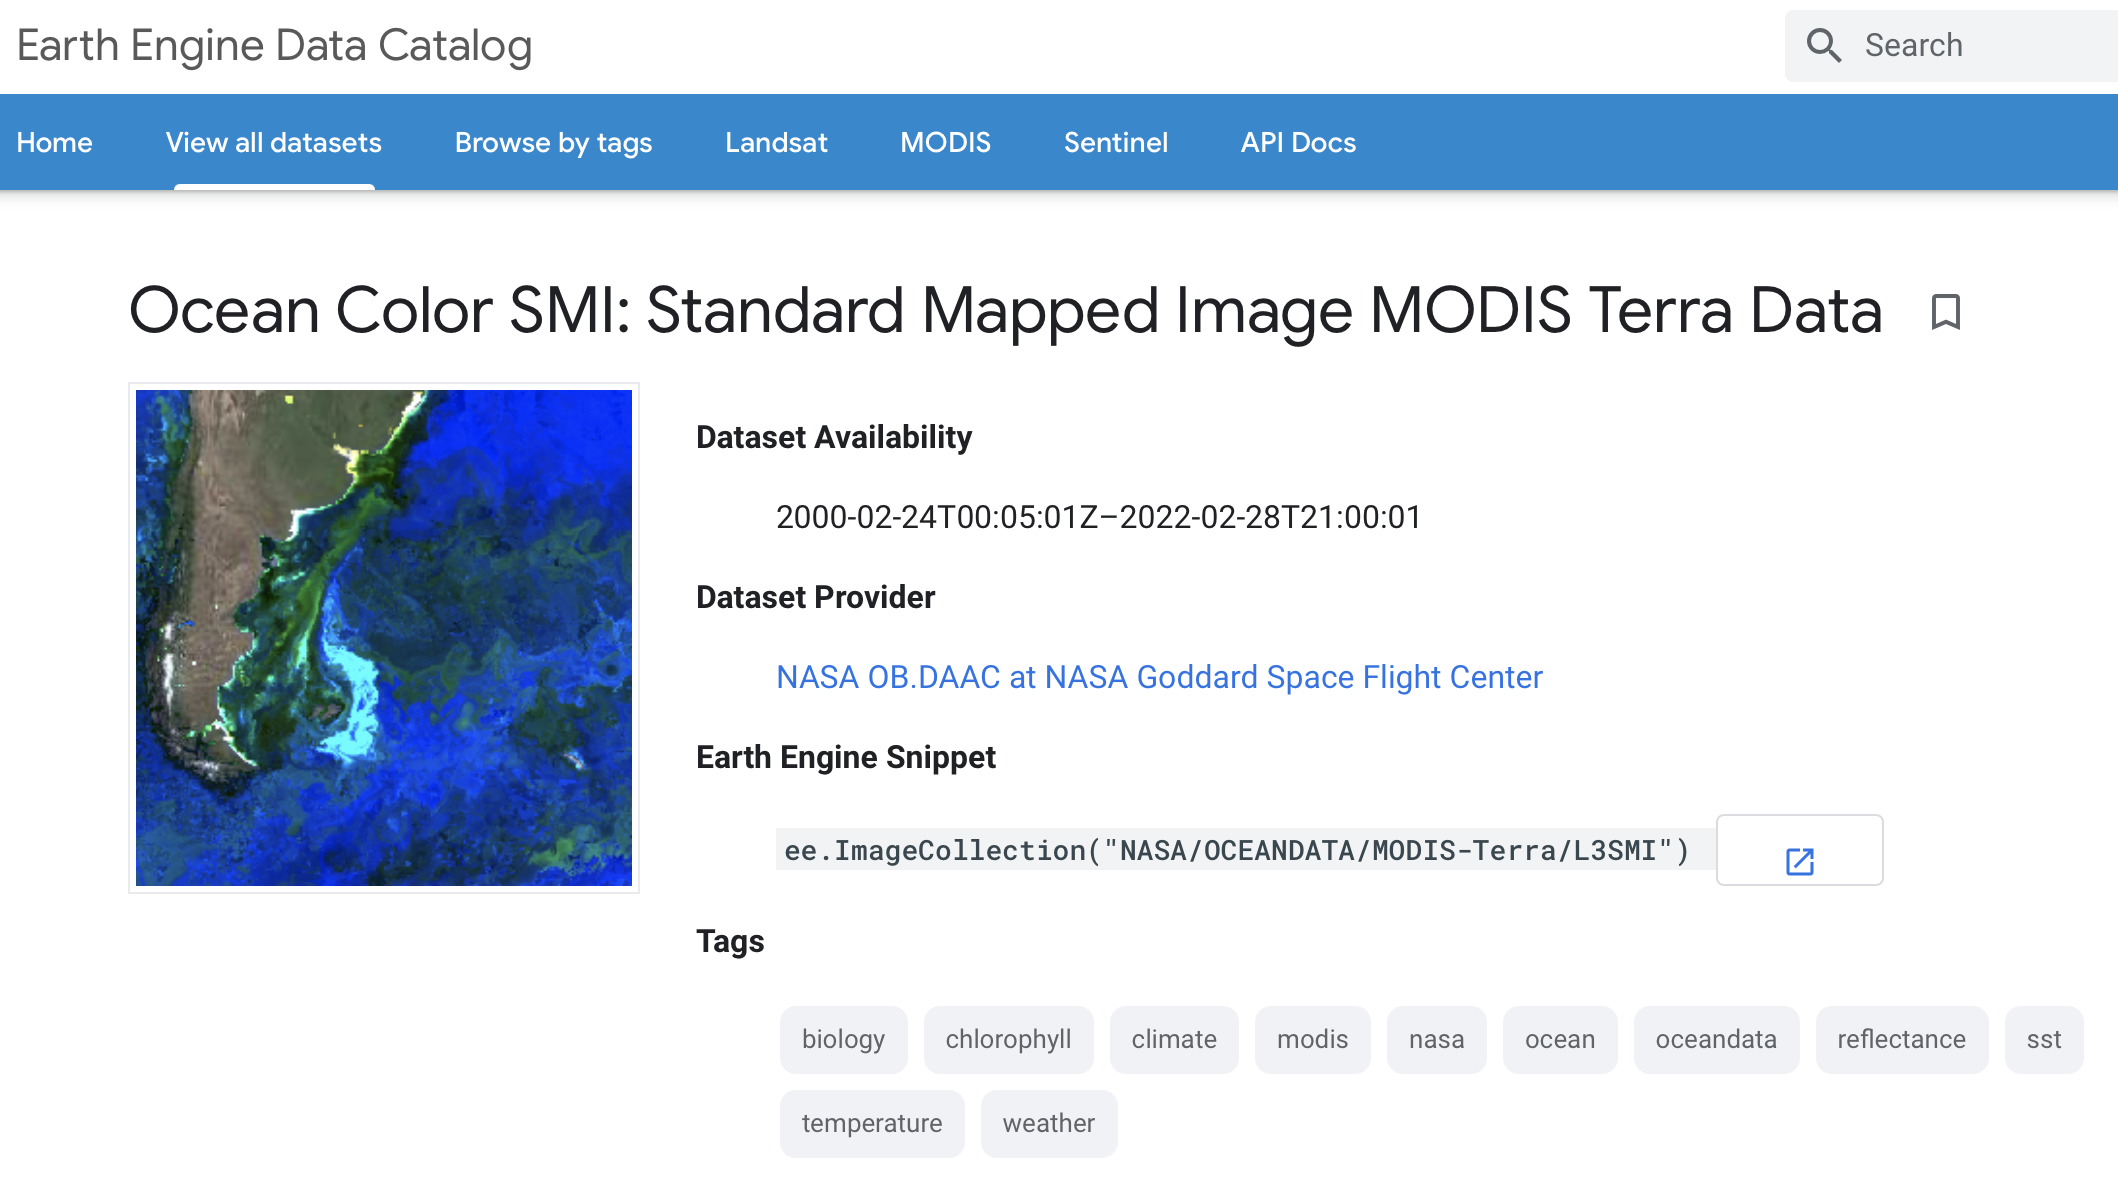

To access the data using Python API `ee`, you need to authenticate first. Run the code below in Python, and it will prompt to enter verification code.

In [2]:
ee.Authenticate() # you need to authenticate first

Enter verification code: 4/1ARtbsJpur6geFCy1W97cvsbhO0FbQYuCIPeuW2yachhVjgXA4go91ktFRoQ

Successfully saved authorization token.


In [3]:
ee.Initialize()   

# connect to the data
modis = ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI")

# get one image showing mean SST from image collection
modis_img = modis.select('sst').filterDate('2020-01-01', '2020-02-01').mean()

#### Plot a web map
Here is an easy way to see a map (You need to run the script to see it.)

In [4]:
lat, lon = 36.817, -121.890   # latitude and longitude of Monterey Bay

Map = geemap.Map(center=(lat, lon), zoom=6)

# visualization parameters
params = {'min': 10,'max': 15, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}

Map.addLayer(modis_img, params)
Map

Map(center=[36.817, -121.89], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

## 2. Fishing activity

Originally developed to avoid vessel collisions at high seas, large industrial fishing vessels are required to transmit their positions at high frequencies to the Automated Information System (AIS). [Global Fishing Watch](https://globalfishingwatch.org) is an NGO that curates and analyzes the AIS data. They recently released an R package `gfwr` (see details [here](https://github.com/GlobalFishingWatch/gfwr)) for easy access to the data.

#### Prerequisites for Global Fishing Watch R API
- Create an account for [Global Fishing Watch](https://gateway.api.globalfishingwatch.org/auth?client=gfw&callback=https%3A%2F%2Fglobalfishingwatch.org%2Four-apis%2Ftokens&locale=en&_ga=2.163787711.1815298001.1661985734-1835116563.1661873072).
- Get a [GFW API access token](https://globalfishingwatch.org/our-apis/tokens).
- In R, load package `usethis`, type and run `edit_r_environ()` and add `GFW_TOKEN = "your token"`, save, and restart R. This will add the token to `.Renviron` file.
- In R, install `gfwr` by typing `devtools::install_github("GlobalFishingWatch/gfwr")`.

#### Example 2

Let's visualize fishing intensity (measured by fishing hours) in 2020. Here, we run R within Python Notebook, but we recommend to run in the R environment.

In [5]:
# install rpy2 (run R in Python) and load
#!pip install rpy2
%load_ext rpy2.ipython

In [6]:
%%R
# run in R 

library(gfwr)
key <- gfw_auth()

# geojson uses LON, LAT (counter-clockwise for a polygon)
region_json = '{"geojson":{"type":"Polygon","coordinates":[[[-31,0],[12,0],[12, 28],[-31, 28],[-31,0]]]}}'

df <- get_raster(spatial_resolution = 'low',     # 'low' is 0.1 degrees, 'high' is 0.01 degree
           temporal_resolution = 'yearly',       # 'yearly', 'monthly', 'daily'
           group_by = 'flag',                    # gfwr requires either 'flag' or 'gearType'
           date_range = '2020-01-01,2021-01-01', # end date is exclusive
           region = region_json,
           region_source = 'user_json',
           key = key)

# save
write.csv(df, 'fishing_hour_w_africa2020.csv')

R[write to console]: Error in library(gfwr) : there is no package called 'gfwr'




Error in library(gfwr) : there is no package called 'gfwr'


RInterpreterError: Failed to parse and evaluate line '# run in R \n\nlibrary(gfwr)\nkey <- gfw_auth()\n\n# geojson uses LON, LAT (counter-clockwise for a polygon)\nregion_json = \'{"geojson":{"type":"Polygon","coordinates":[[[-31,0],[12,0],[12, 28],[-31, 28],[-31,0]]]}}\'\n\ndf <- get_raster(spatial_resolution = \'low\',     # \'low\' is 0.1 degrees, \'high\' is 0.01 degree\n           temporal_resolution = \'yearly\',       # \'yearly\', \'monthly\', \'daily\'\n           group_by = \'flag\',                    # gfwr requires either \'flag\' or \'gearType\'\n           date_range = \'2020-01-01,2021-01-01\', # end date is exclusive\n           region = region_json,\n           region_source = \'user_json\',\n           key = key)\n\n# save\nwrite.csv(df, \'fishing_hour_w_africa2020.csv\')\n'.
R error message: "Error in library(gfwr) : there is no package called 'gfwr'"

In [8]:
# now back in python
data = pd.read_csv('fishing_hour_w_africa2020.csv')
data.head()

,Unnamed: 0,Lat,Lon,Time Range,flag,Apparent Fishing hours
0,1,17.7,-16.3,2020,TUR,20.090556
1,2,18.3,-16.1,2020,MRT,10.888611
2,3,16.8,-16.5,2020,MRT,33.094722
3,4,10.2,-16.1,2020,GIN,382.739722
4,5,9.8,-14.9,2020,ITA,101.402778


In [9]:
# clean up & sum over flag
data = data[['Lat', 'Lon', 'Apparent Fishing hours']]
data = data.groupby(['Lat', 'Lon']).sum()
data.head()

Apparent Fishing hours
Lat Lon                          
0.0 -30.9                2.274722
    -25.4                2.601111
    -25.1                0.903611
    -25.0                2.146944
    -24.7                1.629444

In [10]:
# expand coordinates and replace NA with 0
lats = np.round(np.arange(0, 28, 0.1), 1)
lons = np.round(np.arange(-31, 12, 0.1), 1)

data_expanded = pd.DataFrame([(x, y) for x, y in itertools.product(lats, lons)])
data_expanded.columns = ['Lat', 'Lon']
data_expanded = pd.merge(data_expanded, data, how='left', on=['Lat', 'Lon'])
data_expanded.fillna(0, inplace=True)

#adding a small number for plotting on a log scale
data_expanded['Apparent Fishing hours'] = data_expanded['Apparent Fishing hours'] + 0.01 

data_expanded.set_index(['Lat', 'Lon'], inplace=True)
data_expanded

Apparent Fishing hours
Lat  Lon                          
0.0  -31.0                0.010000
     -30.9                2.284722
     -30.8                0.010000
     -30.7                0.010000
     -30.6                0.010000
...                            ...
27.9  11.5                0.010000
      11.6                0.010000
      11.7                0.010000
      11.8                0.010000
      11.9                0.010000

[120400 rows x 1 columns]

In [11]:
# convert pandas dataframe to xarray for plotting
foo = data_expanded.to_xarray()
foo

<xarray.Dataset>
Dimensions:                 (Lat: 280, Lon: 430)
Coordinates:
  * Lat                     (Lat) float64 0.0 0.1 0.2 0.3 ... 27.7 27.8 27.9
  * Lon                     (Lon) float64 -31.0 -30.9 -30.8 ... 11.7 11.8 11.9
Data variables:
    Apparent Fishing hours  (Lat, Lon) float64 0.01 2.285 0.01 ... 0.01 0.01

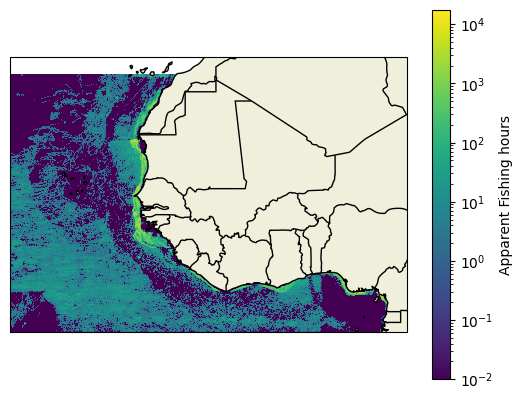

In [12]:
#plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-31, 12, 0, 28])   #x0, x1, y0, y1
foo['Apparent Fishing hours'].plot(ax=ax, zorder=-1, norm=LogNorm(vmin=0.01, vmax=foo['Apparent Fishing hours'].max()))
ax.axes.add_feature(cf.BORDERS)
ax.axes.add_feature(cf.COASTLINE)
ax.axes.add_feature(cf.LAND);

#### Plot the corresponding SSF and Chl-a 

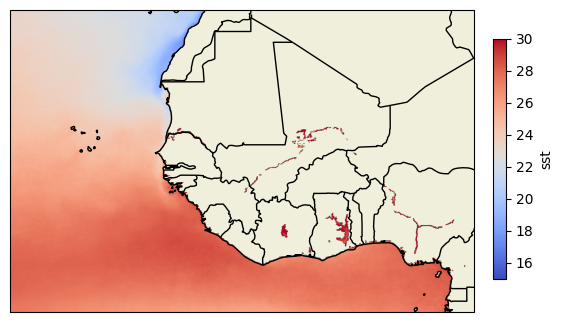

In [13]:
geemap.ee_initialize()

modis = ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI")
foo = modis.filterDate('2020-01-01', '2021-01-01').mean().select("sst", "chlor_a")

params = {'bands':'sst', 'min':15, 'max':30}
p = cartoee.get_map(foo, vis_params=params, region=[12,0,-31,28], cmap='coolwarm')
p.axes.add_feature(cf.BORDERS)
p.axes.add_feature(cf.COASTLINE)
p.axes.add_feature(cf.LAND)
cartoee.add_colorbar(p, vis_params=params, loc='right', cmap='coolwarm')

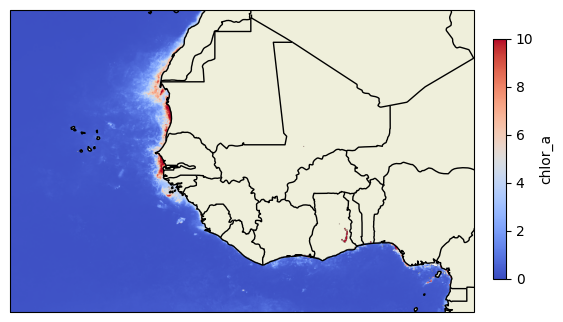

In [14]:
params = {'bands':'chlor_a', 'min':0, 'max':10}
p = cartoee.get_map(foo, vis_params=params, region=[12,0,-31,28], cmap='coolwarm')
p.axes.add_feature(cf.BORDERS)
p.axes.add_feature(cf.COASTLINE)
p.axes.add_feature(cf.LAND)
cartoee.add_colorbar(p, vis_params=params, loc='right', cmap='coolwarm')

#### Example 3
Let's explore how fishing effort has changed over time off Peru.

In [15]:
%%R

library(gfwr)
key <- gfw_auth()

# geojson uses LON, LAT (counter-clockwise for a polygon)
region_json = '{"geojson":{"type":"Polygon","coordinates":[[[-85,-15],[-80,-15],[-80,-10],[-85,-10],[-85,-15]]]}}'

df <- get_raster(spatial_resolution = 'high',     # 'low' is 0.1 degrees, 'high' is 0.01 degree
           temporal_resolution = 'monthly',       # 'yearly', 'monthly', 'daily'
           group_by = 'flag',                    # gfwr requires either 'flag' or 'gearType'
           date_range = '2018-01-01,2022-01-01', # end date is exclusive
           region = region_json,
           region_source = 'user_json',
           key = key)

# save
write.csv(df, 'fishing_hour_peru.csv')

Rows: 86706 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Time Range, flag
dbl (3): Lat, Lon, Apparent Fishing hours

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
# now back in python
fishing = pd.read_csv('fishing_hour_peru.csv')

# clean up
fishing = fishing[['Time Range', 'Apparent Fishing hours']]
fishing = fishing.groupby('Time Range').sum().reset_index()
fishing.columns = ['month', 'fishing_hour']
fishing.tail()

,month,fishing_hour
42,2021-08,5629.542040
43,2021-09,13840.057864
44,2021-10,134.321012
45,2021-11,10717.234127
46,2021-12,71.954719


#### Corresponding SST and Chl-a

In [18]:
# function to get monthly values
def monthly_value(aoi, start, end):    
    foo = modis.select('chlor_a', 'sst').filterDate(start, end).mean()
    bar = foo.reduceRegion(ee.Reducer.mean(), aoi, 1000)
    
    # return NA if error
    try:
        this_sst = bar.get('sst').getInfo()
    except:
        this_sst = np.nan
    
    # same for Chl-a
    try:
        this_chlor_a = bar.get('chlor_a').getInfo()
    except:
        this_chlor_a = np.nan
    
    return(start, this_sst, this_chlor_a)

# list of month (start and end date)
month_list_start = pd.period_range(start='2018-01-01', end='2021-12-01', freq='m').strftime('%Y-%m')
month_list_end = pd.period_range(start='2018-02-01', end='2022-01-01', freq='m').strftime('%Y-%m')

# area of interest
aoi = ee.Geometry.Polygon([[[-85,-15],[-80,-15],[-80,-10],[-85,-10],[-85,-15]]])

climate = [monthly_value(aoi, x, y) for x, y in zip(month_list_start, month_list_end)]
climate = pd.DataFrame(climate)
climate.columns = ['month', 'sst', 'chlor_a']
climate.head()

,month,sst,chlor_a
0,2018-01,23.830756,0.341159
1,2018-02,25.380832,0.290645
2,2018-03,25.554537,0.313327
3,2018-04,25.068351,0.308982
4,2018-05,23.275473,0.404850


In [19]:
# merge two data frames
summary = pd.merge(fishing, climate, how='left', on='month')
summary['month'] = pd.to_datetime(summary['month'])
summary.head()

,month,fishing_hour,sst,chlor_a
0,2018-01-01,427.946953,23.830756,0.341159
1,2018-02-01,85.653891,25.380832,0.290645
2,2018-03-01,191.115275,25.554537,0.313327
3,2018-04-01,61.562778,25.068351,0.308982
4,2018-05-01,170.704722,23.275473,0.404850


#### Plot

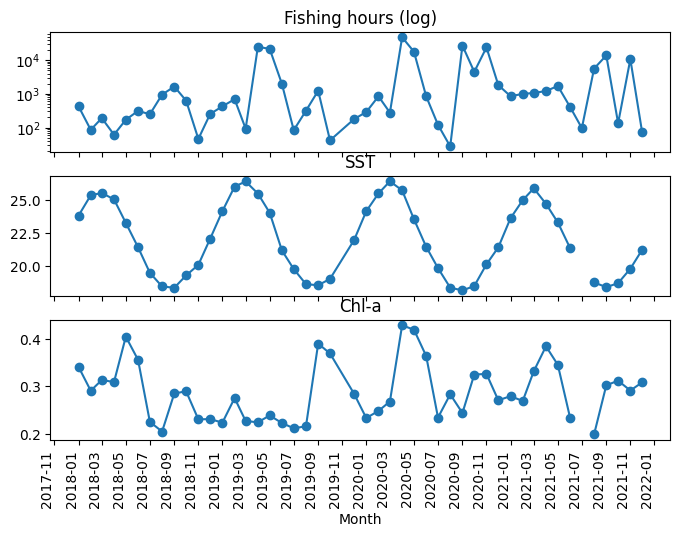

In [20]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot('month', 'fishing_hour', data=summary, marker='o')
ax1.set_xlabel('Month')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.title.set_text('Fishing hours (log)')

ax2.plot('month', 'sst', data=summary, marker='o')
ax2.set_xlabel('Month')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.title.set_text('SST')

ax3.plot('month', 'chlor_a', data=summary, marker='o')
ax3.set_xlabel('Month')
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.title.set_text('Chl-a')

fig.autofmt_xdate(rotation=90)

plt.show()

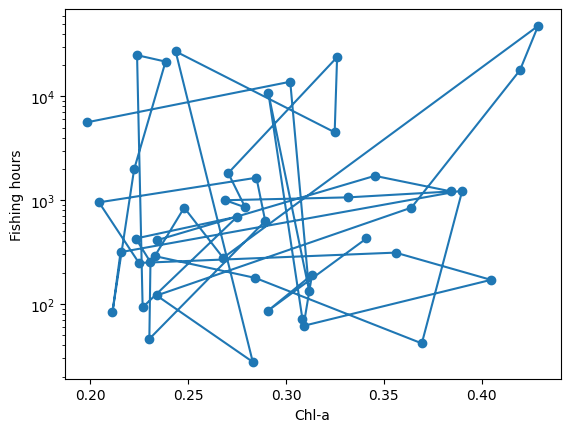

In [21]:
ax = plt.subplot()
ax.plot('chlor_a', 'fishing_hour', data=summary, marker='o')
ax.set_xlabel('Chl-a')
ax.set_ylabel('Fishing hours')
ax.set_yscale('log')
plt.show()

## Assignment

- Select an area of interest and plot time series of monthly fishing effort over several years. Visually explore the seasonal patterns and overall trend, and give possible explanations.
- Compare fishing effort across areas and visually explore trends over time. 